In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

# Birth & Death

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.5, "death": 0.5}
#special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

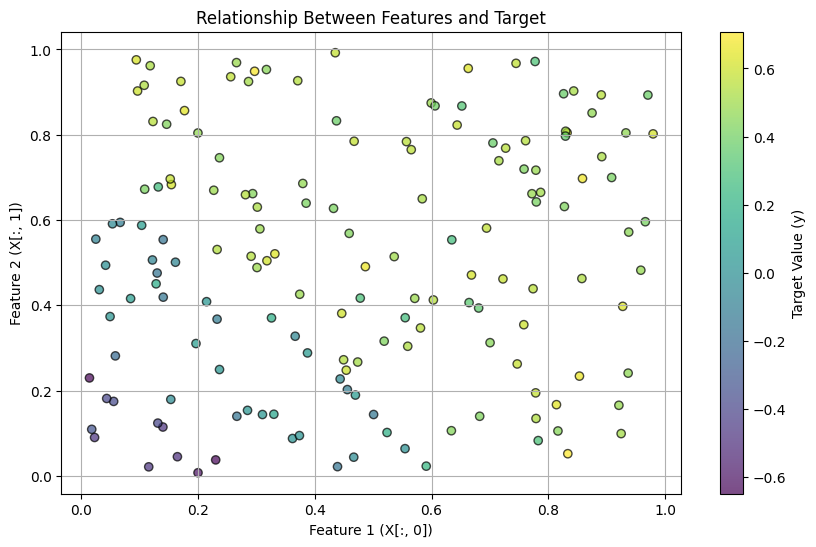

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=2000, nskip=2000, n_trees=50, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 50, theta_df = np.inf, 
                         tree_num_prior_type="poisson", special_move_interval=1)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 4000/4000 [00:40<00:00, 98.09it/s] 


In [5]:
bart.trace[-1].n_trees

52

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00771762]), 'ntree_theta': 50}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

51.336

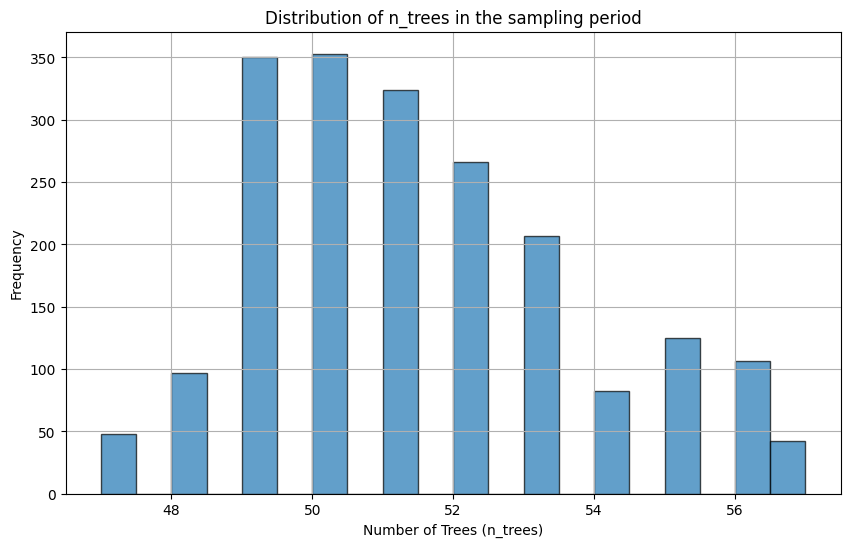

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

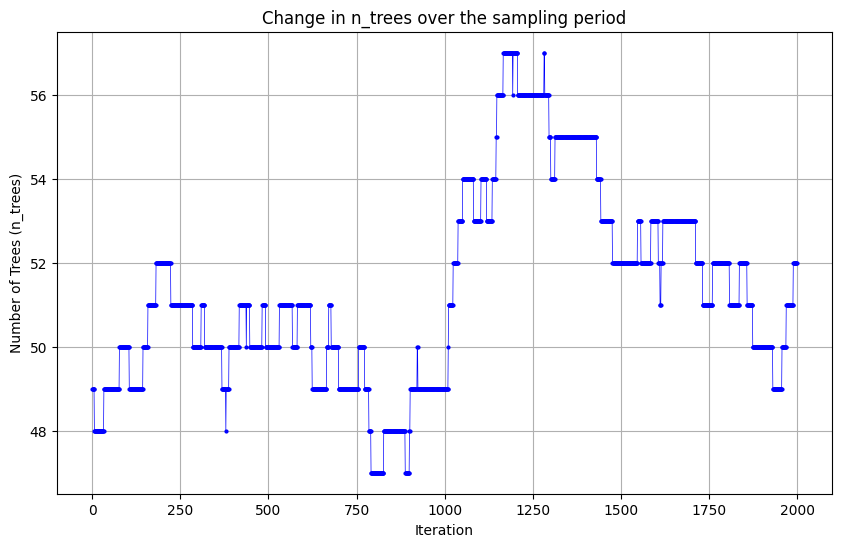

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 2025; mh median: 0.030992174124490034


In [11]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 83; mh median: 27.56873385823128


In [12]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-05-13 00:34:29,355:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-13 00:34:29,357:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.33 A_prune=0.23 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.37 A_prune=0.44
Iteration 300/300 P_grow=0.46 P_prune=0.54 A_grow=0.29 A_prune=0.43


In [13]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.02225841447932291,
 'rf': 0.022655748813701505,
 'lr': 0.048045521328019404,
 'btz': 0.025221175773841288}

In [14]:
bart.trace[-1].trees

[Tree(vars=[ 1 -1  0 -2 -2 -1 -1 -2], thresholds=[0.49110105        nan 0.44836788        nan        nan        nan
         nan        nan], leaf_vals=[        nan  0.02954916         nan         nan         nan  0.02330987
  -0.00687812         nan], n_vals=[120  58  62  -2  -2  33  29  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.02206496        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.01100397 0.01719225        nan        nan        nan
         nan        nan], n_vals=[120   3 117  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.19767083        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan  0.04950748 -0.00697881         nan         nan         nan
          nan         nan], n_vals=[120  28  92  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.57122029        nan        nan        nan        nan        nan
    

In [15]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [16]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True

In [17]:
bart.sampler.trace[-1].evaluate()

array([ 0.33973664,  0.30923337,  0.25391114,  0.26677265,  0.40249603,
        0.38307625, -0.26327966,  0.35965626, -0.11354287,  0.1396877 ,
        0.28128247,  0.28882363,  0.3629486 ,  0.31131454,  0.28573406,
        0.29238155,  0.01021408,  0.28902846,  0.32666447,  0.3096307 ,
       -0.00387372, -0.3427488 ,  0.29979886,  0.28617132,  0.38569545,
        0.34147575,  0.31784457,  0.35228247,  0.30869804,  0.35652323,
       -0.38038023,  0.44760455,  0.06459128,  0.12767498,  0.37413283,
        0.3855446 ,  0.24755497,  0.28110359, -0.38327753,  0.10627307,
        0.32886248,  0.29238155,  0.47839895, -0.0241571 ,  0.03149551,
        0.38156891, -0.30848251,  0.40018774,  0.34147575, -0.04714137,
        0.33233161,  0.3008773 ,  0.40566129,  0.47839895,  0.30275305,
       -0.04383289,  0.4236671 ,  0.37486751,  0.3314537 ,  0.24066372,
        0.37364738,  0.33973664,  0.27708781,  0.39286272,  0.02215192,
        0.26656781,  0.21701191, -0.07900081,  0.20325331,  0.00

In [18]:
bart.sampler.trace[-1].evaluate(X_train)

array([ 0.33973664,  0.30923337,  0.25391114,  0.26677265,  0.40249603,
        0.38307625, -0.26327966,  0.35965626, -0.11354287,  0.1396877 ,
        0.28128247,  0.28882363,  0.3629486 ,  0.31131454,  0.28573406,
        0.29238155,  0.01021408,  0.28902846,  0.32666447,  0.3096307 ,
       -0.00387372, -0.3427488 ,  0.29979886,  0.28617132,  0.38569545,
        0.34147575,  0.31784457,  0.35228247,  0.30869804,  0.35652323,
       -0.38038023,  0.44760455,  0.06459128,  0.12767498,  0.37413283,
        0.3855446 ,  0.24755497,  0.28110359, -0.38327753,  0.10627307,
        0.32886248,  0.29238155,  0.47839895, -0.0241571 ,  0.03149551,
        0.38156891, -0.30848251,  0.40018774,  0.34147575, -0.04714137,
        0.33233161,  0.3008773 ,  0.40566129,  0.47839895,  0.30275305,
       -0.04383289,  0.4236671 ,  0.37486751,  0.3314537 ,  0.24066372,
        0.37364738,  0.33973664,  0.27708781,  0.39286272,  0.02215192,
        0.26656781,  0.21701191, -0.07900081,  0.20325331,  0.00